In [126]:
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
from PIL import Image, ImageFile
import math

from keras import backend as K
from keras import layers, models, optimizers
from keras.utils import np_utils
from keras.utils.np_utils import to_categorical  
from keras.applications import vgg16, inception_v3, resnet50
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.models import Model, Sequential
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.optimizers import Adam, Adagrad, RMSprop, SGD


from sklearn.datasets import load_files 

ImageFile.LOAD_TRUNCATED_IMAGES = True

# Ideas and TODOs

- Try FineTuning the pretrained networks
- Visualize training with Tensorboard
- bottleneck features: http://blog.ethanrosenthal.com/2016/12/05/recasketch-keras/
- tutorial: https://www.codesofinterest.com/2017/08/bottleneck-features-multi-class-classification-keras.html

# Data Exploration

In [3]:
def load_dataset(path, num_classes=3):
    """Load train, test, valid datasets"""
    
    data = load_files(path)
    files = np.array(data['filenames'])
    targets = np_utils.to_categorical(np.array(data['target']), num_classes)
    
    return files, targets

In [4]:
# Loading valid, train and test datasets
train_path = 'data/train'
valid_path = 'data/valid'
test_path ='data/test'

valid_files, valid_targets = load_dataset(valid_path)
train_files, train_targets = load_dataset(train_path)
test_files, test_targets = load_dataset(test_path)

In [5]:
# load list of classes
class_names = [item[11:-1] for item in sorted(glob("data/train/*/"))]

In [6]:
# Statistics about the dataset
print('%d classes: %s' % (len(class_names), ", ".join(class_names)))
print('%d training images' % len(train_files))
print('%d validation images' % len(valid_files))
print('%d test images' % len(test_files))

3 classes: melanoma, nevus, seborrheic_keratosis
2000 training images
150 validation images
600 test images


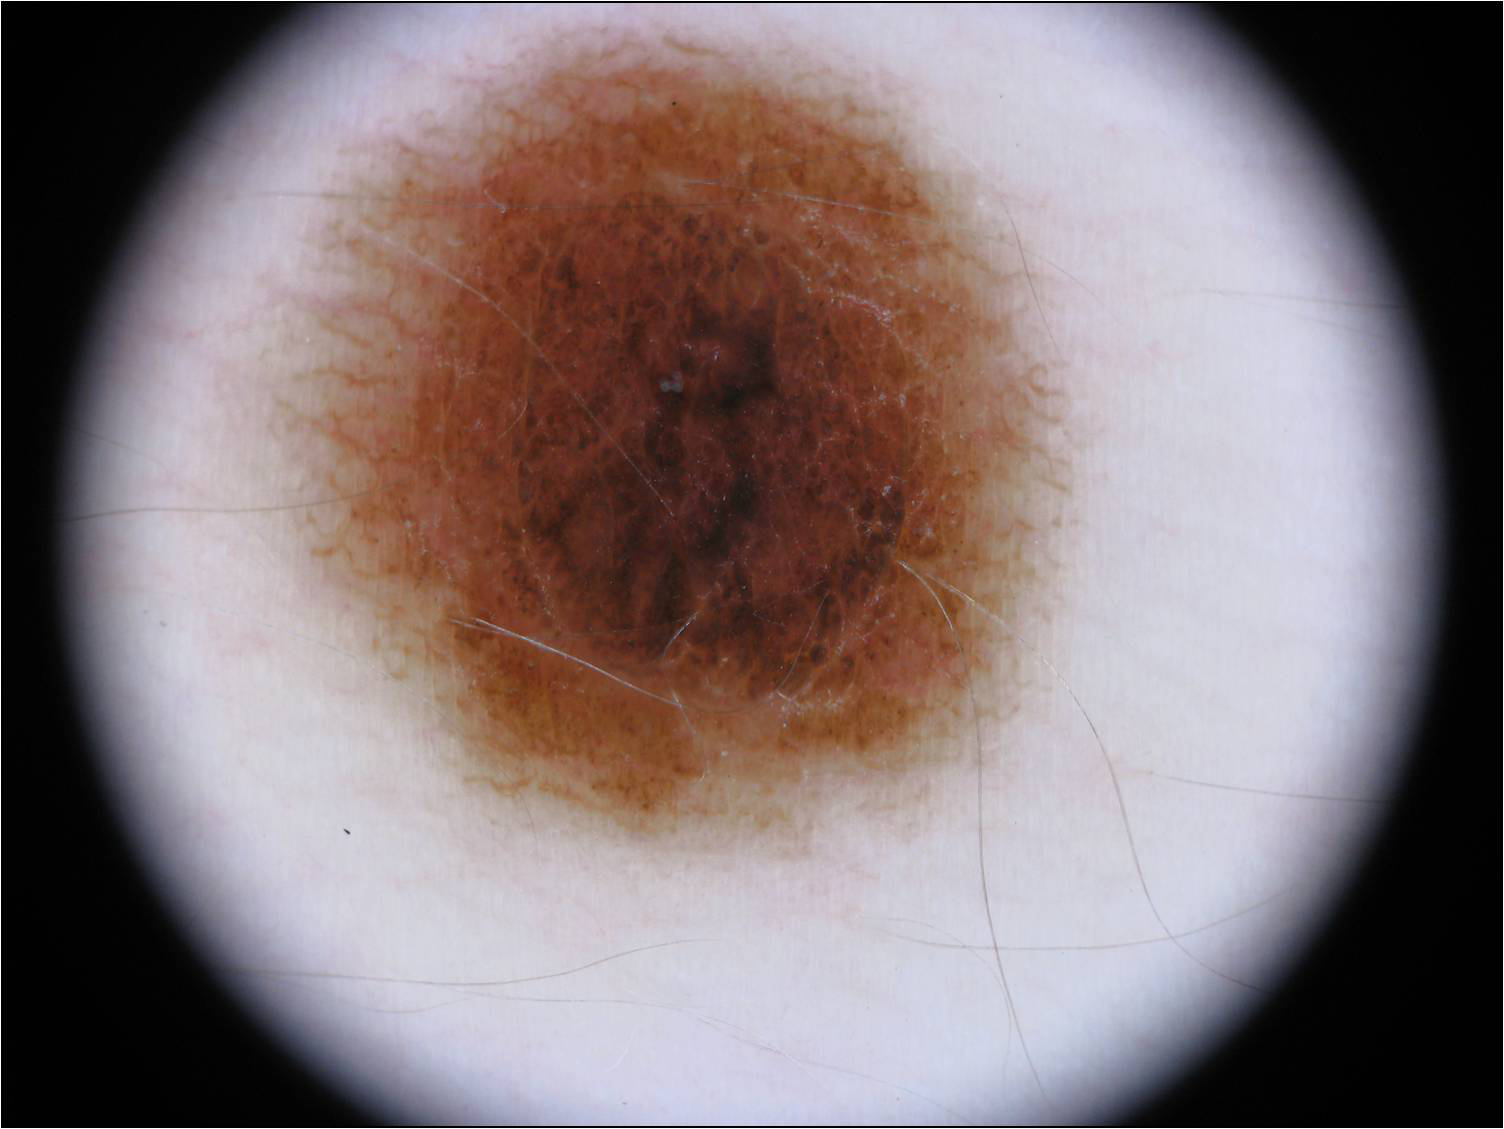

In [7]:
im = Image.open(train_files[0])
im

In [8]:
im.size

(1504, 1129)

## Visualizing the Dataset

In [9]:
def load_image(filename) :
    img = Image.open(filename)
    img.load()
    return np.asarray(img)

def load_data(filenames, n_load=20):
    return np.array([load_image(filename) for filename in filenames[0:n_load]])

def visualize_images(data, targets):
    fig = plt.figure(figsize=(20,5))
    for i in range(12):
        ax = fig.add_subplot(3, 4, i + 1, xticks=[], yticks=[])
        plt.gca().set_title(str(targets[i]))
        ax.imshow(np.squeeze(data[i]))

In [10]:
n_load = 20
train_images = load_data(train_files, n_load=n_load)

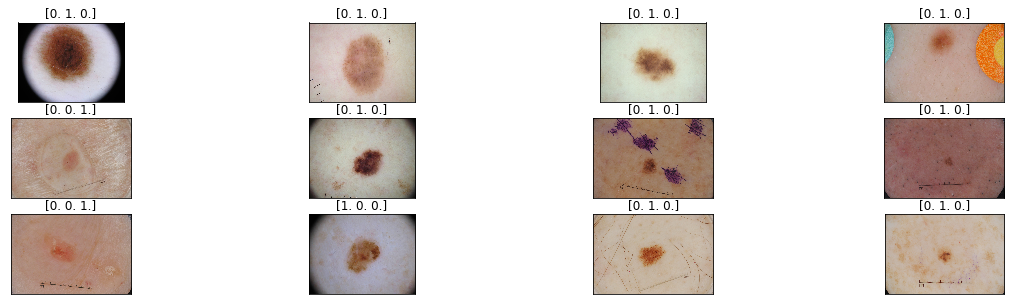

In [11]:
%matplotlib inline

visualize_images(train_images, train_targets)

# Model

## Data Generator

In [14]:
def make_generators(generator_config, model_config, train_path='data/train', valid_path='data/valid', test_path='data/test'):
    
    # Data Generators
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=generator_config['shear_range'],
        zoom_range=generator_config['zoom_range'],
        horizontal_flip=generator_config['horizontal_flip']
    )

    validation_datagen = ImageDataGenerator(rescale=1./255)
    test_datagen = ImageDataGenerator(rescale=1./255)
    
    train_generator = train_datagen.flow_from_directory(
        train_path,                               # this is the target directory
        target_size=model_config['target_size'],  # all images will be resized to target_size
        batch_size=algo_config['batch_size'],
        class_mode='categorical'
    )    

    # this is a similar generator, for validation data
    validation_generator = validation_datagen.flow_from_directory(
        valid_path,
        target_size=model_config['target_size'],  # all images will be resized to target_size
        batch_size=algo_config['batch_size'],
        class_mode='categorical'
    )
    
    # this is a similar generator, for test data
    test_generator = test_datagen.flow_from_directory(
        test_path,
        target_size=model_config['target_size'],  # all images will be resized to target_size
        batch_size=algo_config['batch_size'],
        class_mode='categorical'
    )
    
    return train_datagen, train_generator, validation_datagen, validation_generator, test_datagen, test_generator

## Architecture and Pretrained Layers

In [15]:
def make_base_model(model_config, derived_config):
    """Make Base Model from VGG16, ResNet50, Inception..."""
    if model_config['base_model'] == 'VGG16':

        base_model = vgg16.VGG16(
            weights='imagenet', 
            include_top=False,
            input_shape=derived_config['input_shape']
        )
    elif model_config['base_model'] == 'ResNet50':

        base_model = resnet50.ResNet50(
            weights='imagenet', 
            include_top=False,
            input_shape=derived_config['input_shape']
        )
    else:
        raise "Please Provide a `base_model` key in model_config"

    return base_model


def make_model(model_config, derived_config, verbose=True):
    """Make Model using the provided config"""
    
    
    def build_model(model_config, num_classes, base_model):

        x0 = base_model.output
        x1 = Flatten()(x0)
        x2 = Dense(model_config['hidden_units'], activation='relu')(x1)
        x3 = Dropout(model_config['dropout'])(x2)
        
        y = Dense(num_classes, activation='softmax')(x3)

        model = Model(inputs=base_model.input, outputs=y)
    
        return model


    def freeze_base_layers(base_model):
    
        # Freeze base model layers
        for layer in base_model.layers:
            layer.trainable = False
    
    
    # Building the pretrained model
    base_model = make_base_model(model_config, derived_config)
    freeze_base_layers(base_model)
    model = build_model(model_config, 3, base_model)
    
    if verbose:
        model.summary()
        
    return model

In [16]:
def compile_model(model, algo_config):
    
    def make_optimizer(algo_config):
        """Make Optimizer based on algo_config map"""
        
        if algo_config['optimizer'] == 'adam':
            optimizer = Adam(algo_config['lr'])
        elif algo_config['optimizer'] == 'rmsprop':
            optimizer = RMSprop(algo_config['lr'])
        else:
            raise "Please Provide an Optimizer"
        return optimizer

        
    optimizer = make_optimizer(algo_config)
    model.compile(
        optimizer=optimizer, 
        loss='categorical_crossentropy',
        metrics=['categorical_accuracy', 'accuracy']
    )
    
    return model

## Training

In [17]:
def train_model(model, train_generator, validation_generator, algo_config):
    
    history = model.fit_generator(
        train_generator,
        steps_per_epoch=train_generator.samples / train_generator.batch_size,
        epochs=algo_config['epochs'],
        validation_data=validation_generator,
        validation_steps=validation_generator.samples / validation_generator.batch_size
    )
    
    return history
    
    

def make_train_model(algo_config, model_config, generator_config, derived_config, verbose=True):
    
    print('Building generators...')
    train_datagen, train_generator, validation_datagen, validation_generator, test_datagen, test_generator = make_generators(generator_config, model_config)
    
    print('Making model...')
    model = make_model(model_config, derived_config, verbose=verbose)
    
    print('Compiling model...')
    compile_model(model, algo_config)
    
    print('Training model...')
    history = train_model(model, train_generator, validation_generator, algo_config)
    
    return train_generator, validation_generator, test_generator, model, history

### Baseline Model

In [45]:
# Config
algo_config = {
    'batch_size': 32,
    'optimizer': 'adam',
    'lr': 0.001,
    'epochs': 5,
}

model_config = {
    'hidden_units': 10,
    'dropout': 0.5,
    'target_size': (300, 300), 
    'base_model': 'VGG16',
}

generator_config = {
    'shear_range': 0.2,
    'zoom_range': 0.2,
    'horizontal_flip': True,
}


# Derived Config
def make_derived_config(model_config):
    w, h = model_config['target_size']
    return {
        'input_shape': (w, h, 3)
    }

derived_config = make_derived_config(model_config)

In [ ]:
print('Building generators...')
train_datagen, train_generator, validation_datagen, validation_generator, test_datagen, test_generator = make_generators(generator_config, model_config)
    
print('Making model...')
model = make_model(model_config, derived_config, verbose=verbose)
    
print('Compiling model...')
compile_model(model, algo_config)
    
print('Training model...')
history = train_model(model, train_generator, validation_generator, algo_config)

# train_generator, validation_generator, test_generator, model, history = make_train_model(algo_config, model_config, generator_config, derived_config)

In [ ]:
model.evaluate_generator(test_generator, verbose=1)

## Bottleneck features

Training is very very very slow because it has to recompute again and again the same features to feed to the top layers. Let's cache thi computation and speed up the process!

### Generate Bottleneck Features

In [120]:
# Config
algo_config = {
    'batch_size': 32,
    'optimizer': 'adam',
    'lr': 0.001,
    'epochs': 5,
}

model_config = {
    'hidden_units': 100,
    'dropout': 0.5,
    'target_size': (600, 600), 
    'base_model': 'ResNet50',
}

generator_config = {
    'shear_range': 0.2,
    'zoom_range': 0.2,
    'horizontal_flip': True,
}


# Derived Config
def make_derived_config(model_config):
    w, h = model_config['target_size']
    return {
        'input_shape': (w, h, 3)
    }

derived_config = make_derived_config(model_config)

In [121]:
# Generating base model removing the top
base_model = make_base_model(model_config, derived_config)

# Generators
train_datagen, train_generator, validation_datagen, validation_generator, test_datagen, test_generator = make_generators(generator_config, model_config)

# Config
target_size = model_config['target_size']
batch_size = algo_config['batch_size']

Found 2000 images belonging to 3 classes.
Found 150 images belonging to 3 classes.
Found 600 images belonging to 3 classes.


In [122]:
def make_bottleneck_features_filename(set_type, model_config):
    """set_type is in {'valid', 'test', 'train'}"""
    
    w, h = model_config['target_size']
    filename = str(w) + 'x' + str(h) + '_' + model_config['base_model'] + '_' + set_type + '_bottleneck_features.npy'

    return filename
    
    
def save_bottleneck_features_to_disk(bottleneck_features, set_type, model_config):
    """set_type is in {'valid', 'test', 'train'}"""
    
    filename = make_bottleneck_features_filename(set_type, model_config)
    np.save(open(filename, 'wb'), bottleneck_features)
    
    return True


def load_bottleneck_features_from_disk(set_type, model_config):
    """set_type is in {'valid', 'test', 'train'}"""
    
    filename = make_bottleneck_features_filename(set_type, model_config)
    
    return np.load(open(filename, 'rb'))

In [123]:
# Training Generator
train_bottleneck_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=target_size,
    batch_size=batch_size,
    class_mode=None, 
    shuffle=False     # our data will be in order, so all first 1000 images will be first class, then 1000 will be second class
)

nb_train_samples = len(train_bottleneck_generator.filenames)
num_classes = len(train_bottleneck_generator.class_indices)
predict_size_train = int(math.ceil(nb_train_samples / batch_size))

bottleneck_features_train = base_model.predict_generator(  
    train_bottleneck_generator, 
    predict_size_train,
    verbose=1
)

# Saving to disk
save_bottleneck_features_to_disk(bottleneck_features_train, 'train', model_config)

Found 2000 images belonging to 3 classes.
63/63 [==============================] - 476s 8s/step


True

In [124]:
# Validation Generator
valid_bottleneck_generator = validation_datagen.flow_from_directory(
    valid_path,
    target_size=target_size,
    batch_size=batch_size,
    class_mode=None, 
    shuffle=False     # our data will be in order, so all first 1000 images will be first class, then 1000 will be second class
)

nb_valid_samples = len(valid_bottleneck_generator.filenames)
num_classes = len(valid_bottleneck_generator.class_indices)
predict_size_valid = int(math.ceil(nb_valid_samples / batch_size))

bottleneck_features_valid = base_model.predict_generator(  
    valid_bottleneck_generator, 
    predict_size_valid,
    verbose=1
)

# Saving to disk
save_bottleneck_features_to_disk(bottleneck_features_valid, 'valid', model_config)

Found 150 images belonging to 3 classes.
5/5 [==============================] - 46s 9s/step


True

In [125]:
# Test Generator
test_bottleneck_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=target_size,
    batch_size=batch_size,
    class_mode=None, 
    shuffle=False     # our data will be in order, so all first 1000 images will be first class, then 1000 will be second class
)

nb_test_samples = len(test_bottleneck_generator.filenames)
num_classes = len(test_bottleneck_generator.class_indices)
predict_size_test = int(math.ceil(nb_test_samples / batch_size))

bottleneck_features_test = base_model.predict_generator(  
    test_bottleneck_generator, 
    predict_size_test,
    verbose=1
)

# Saving to disk
save_bottleneck_features_to_disk(bottleneck_features_test, 'test', model_config)

Found 600 images belonging to 3 classes.
19/19 [==============================] - 269s 14s/step


True

### Small Fully Connected Baseline Model

#### Loading Bottleneck Features

In [127]:
train_datagen, train_generator, validation_datagen, validation_generator, test_datagen, test_generator = make_generators(generator_config, model_config)

Found 2000 images belonging to 3 classes.
Found 150 images belonging to 3 classes.
Found 600 images belonging to 3 classes.


In [128]:
# Loading bottleneck features from disk
train_data = load_bottleneck_features_from_disk('train', model_config)
valid_data = load_bottleneck_features_from_disk('valid', model_config)
test_data = load_bottleneck_features_from_disk('test', model_config)

# Loading labels
train_labels = to_categorical(train_bottleneck_generator.classes, num_classes=num_classes)
valid_labels = to_categorical(valid_bottleneck_generator.classes, num_classes=num_classes)
test_labels = to_categorical(test_bottleneck_generator.classes, num_classes=num_classes)


print('Data shape:')
print(train_data.shape)
print(valid_data.shape)
print(test_data.shape)

print('\nLabel shape:')
print(train_labels.shape)
print(valid_labels.shape)
print(test_labels.shape)

Data shape:
(2000, 2, 2, 2048)
(150, 2, 2, 2048)
(600, 2, 2, 2048)

Label shape:
(2000, 3)
(150, 3)
(600, 3)


#### Model Architecure

In [129]:
# Model Architecture
small_model = Sequential()
small_model.add(Flatten(input_shape=train_data.shape[1:]))
small_model.add(Dense(100, activation='relu'))
small_model.add(Dropout(0.5))
small_model.add(Dense(3, activation='sigmoid'))

In [130]:
small_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['categorical_accuracy', 'accuracy']
)

In [131]:
small_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_8 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_15 (Dense)             (None, 100)               819300    
_________________________________________________________________
dropout_8 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 3)                 303       
Total params: 819,603
Trainable params: 819,603
Non-trainable params: 0
_________________________________________________________________


In [133]:
small_model.fit(
    train_data, 
    train_labels,
    epochs=300,
    batch_size=algo_config['batch_size'],
    validation_data=(valid_data, valid_labels)
)

Train on 2000 samples, validate on 150 samples
Epoch 1/300
2000/2000 [==============================] - 0s 165us/step - loss: 0.8342 - categorical_accuracy: 0.6860 - acc: 0.6860 - val_loss: 1.1090 - val_categorical_accuracy: 0.5200 - val_acc: 0.5200
Epoch 2/300
2000/2000 [==============================] - 0s 161us/step - loss: 0.8342 - categorical_accuracy: 0.6860 - acc: 0.6860 - val_loss: 1.1093 - val_categorical_accuracy: 0.5200 - val_acc: 0.5200
Epoch 3/300
2000/2000 [==============================] - 0s 163us/step - loss: 0.8342 - categorical_accuracy: 0.6860 - acc: 0.6860 - val_loss: 1.1094 - val_categorical_accuracy: 0.5200 - val_acc: 0.5200
Epoch 4/300
2000/2000 [==============================] - 0s 162us/step - loss: 0.8342 - categorical_accuracy: 0.6860 - acc: 0.6860 - val_loss: 1.1092 - val_categorical_accuracy: 0.5200 - val_acc: 0.5200
Epoch 5/300
2000/2000 [==============================] - 0s 164us/step - loss: 0.8342 - categorical_accuracy: 0.6860 - acc: 0.6860 - val_loss

Epoch 41/300
2000/2000 [==============================] - 0s 164us/step - loss: 0.8342 - categorical_accuracy: 0.6860 - acc: 0.6860 - val_loss: 1.1090 - val_categorical_accuracy: 0.5200 - val_acc: 0.5200
Epoch 42/300
2000/2000 [==============================] - 0s 162us/step - loss: 0.8342 - categorical_accuracy: 0.6860 - acc: 0.6860 - val_loss: 1.1089 - val_categorical_accuracy: 0.5200 - val_acc: 0.5200
Epoch 43/300
2000/2000 [==============================] - 0s 165us/step - loss: 0.8342 - categorical_accuracy: 0.6860 - acc: 0.6860 - val_loss: 1.1086 - val_categorical_accuracy: 0.5200 - val_acc: 0.5200
Epoch 44/300
2000/2000 [==============================] - 0s 163us/step - loss: 0.8342 - categorical_accuracy: 0.6860 - acc: 0.6860 - val_loss: 1.1087 - val_categorical_accuracy: 0.5200 - val_acc: 0.5200
Epoch 45/300
2000/2000 [==============================] - 0s 163us/step - loss: 0.8342 - categorical_accuracy: 0.6860 - acc: 0.6860 - val_loss: 1.1091 - val_categorical_accuracy: 0.520

2000/2000 [==============================] - 0s 162us/step - loss: 0.8342 - categorical_accuracy: 0.6860 - acc: 0.6860 - val_loss: 1.1093 - val_categorical_accuracy: 0.5200 - val_acc: 0.5200
Epoch 82/300
2000/2000 [==============================] - 0s 163us/step - loss: 0.8342 - categorical_accuracy: 0.6860 - acc: 0.6860 - val_loss: 1.1093 - val_categorical_accuracy: 0.5200 - val_acc: 0.5200
Epoch 83/300
2000/2000 [==============================] - 0s 162us/step - loss: 0.8342 - categorical_accuracy: 0.6860 - acc: 0.6860 - val_loss: 1.1091 - val_categorical_accuracy: 0.5200 - val_acc: 0.5200
Epoch 84/300
2000/2000 [==============================] - 0s 164us/step - loss: 0.8342 - categorical_accuracy: 0.6860 - acc: 0.6860 - val_loss: 1.1089 - val_categorical_accuracy: 0.5200 - val_acc: 0.5200
Epoch 85/300
2000/2000 [==============================] - 0s 163us/step - loss: 0.8342 - categorical_accuracy: 0.6860 - acc: 0.6860 - val_loss: 1.1092 - val_categorical_accuracy: 0.5200 - val_acc: 

KeyboardInterrupt: 

In [134]:
small_model.evaluate(test_data, test_labels)

600/600 [==============================] - 0s 75us/step


[0.8833417018254598, 0.655, 0.655]

## Model Iterations

In [116]:
# Config
algo_config = {
    'batch_size': 32,
    'optimizer': 'adam',
    'lr': 0.001,
    'epochs': 500,
}

model_config = {
    'hidden_units': 10,
    'dropout': 0.5,
    'target_size': (300, 300), 
    'base_model': 'VGG16',
}

In [117]:
def make_small_model(train_data, model_config, algo_config):

    # Model Architecture
    small_model = Sequential()
    small_model.add(Flatten(input_shape=train_data.shape[1:]))
    small_model.add(Dense(model_config['hidden_units'], activation='relu'))
    small_model.add(Dropout(model_config['dropout']))
    small_model.add(Dense(3, activation='sigmoid'))
    
    compile_model(small_model, algo_config)
    small_model.summary()
    
    return small_model

In [118]:
small_model = make_small_model(train_data, model_config, algo_config)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_7 (Flatten)          (None, 41472)             0         
_________________________________________________________________
dense_13 (Dense)             (None, 10)                414730    
_________________________________________________________________
dropout_7 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 3)                 33        
Total params: 414,763
Trainable params: 414,763
Non-trainable params: 0
_________________________________________________________________


In [119]:
small_model.fit(
    train_data, 
    train_labels,
    epochs=algo_config['epochs'],
    batch_size=algo_config['batch_size'],
    validation_data=(valid_data, valid_labels)
)

Train on 2000 samples, validate on 150 samples
Epoch 1/500
2000/2000 [==============================] - 1s 401us/step - loss: 1.0619 - categorical_accuracy: 0.4380 - acc: 0.4380 - val_loss: 1.0986 - val_categorical_accuracy: 0.2133 - val_acc: 0.2133
Epoch 2/500
2000/2000 [==============================] - 0s 248us/step - loss: 1.0351 - categorical_accuracy: 0.4360 - acc: 0.4360 - val_loss: 1.0986 - val_categorical_accuracy: 0.2267 - val_acc: 0.2267
Epoch 3/500
2000/2000 [==============================] - 0s 249us/step - loss: 1.0219 - categorical_accuracy: 0.4295 - acc: 0.4295 - val_loss: 1.0986 - val_categorical_accuracy: 0.2267 - val_acc: 0.2267
Epoch 4/500
2000/2000 [==============================] - 1s 250us/step - loss: 1.0116 - categorical_accuracy: 0.4275 - acc: 0.4275 - val_loss: 1.0986 - val_categorical_accuracy: 0.2133 - val_acc: 0.2133
Epoch 5/500
2000/2000 [==============================] - 0s 249us/step - loss: 1.0065 - categorical_accuracy: 0.4335 - acc: 0.4335 - val_loss

Epoch 41/500
2000/2000 [==============================] - 1s 253us/step - loss: 0.7323 - categorical_accuracy: 0.6860 - acc: 0.6860 - val_loss: 0.9729 - val_categorical_accuracy: 0.5200 - val_acc: 0.5200
Epoch 42/500
2000/2000 [==============================] - 1s 251us/step - loss: 0.7241 - categorical_accuracy: 0.6860 - acc: 0.6860 - val_loss: 1.0050 - val_categorical_accuracy: 0.5200 - val_acc: 0.5200
Epoch 43/500
2000/2000 [==============================] - 1s 251us/step - loss: 0.7264 - categorical_accuracy: 0.6860 - acc: 0.6860 - val_loss: 0.9612 - val_categorical_accuracy: 0.5200 - val_acc: 0.5200
Epoch 44/500
2000/2000 [==============================] - 1s 250us/step - loss: 0.7365 - categorical_accuracy: 0.6860 - acc: 0.6860 - val_loss: 1.0751 - val_categorical_accuracy: 0.5200 - val_acc: 0.5200
Epoch 45/500
2000/2000 [==============================] - 1s 257us/step - loss: 0.7312 - categorical_accuracy: 0.6860 - acc: 0.6860 - val_loss: 0.9831 - val_categorical_accuracy: 0.520

2000/2000 [==============================] - 1s 254us/step - loss: 0.7123 - categorical_accuracy: 0.6860 - acc: 0.6860 - val_loss: 1.2912 - val_categorical_accuracy: 0.5200 - val_acc: 0.5200
Epoch 122/500
2000/2000 [==============================] - 1s 250us/step - loss: 0.7150 - categorical_accuracy: 0.6860 - acc: 0.6860 - val_loss: 1.2949 - val_categorical_accuracy: 0.5200 - val_acc: 0.5200
Epoch 123/500
2000/2000 [==============================] - 1s 251us/step - loss: 0.6945 - categorical_accuracy: 0.6860 - acc: 0.6860 - val_loss: 1.2023 - val_categorical_accuracy: 0.5200 - val_acc: 0.5200
Epoch 124/500
2000/2000 [==============================] - 1s 250us/step - loss: 0.6818 - categorical_accuracy: 0.6860 - acc: 0.6860 - val_loss: 1.2925 - val_categorical_accuracy: 0.5200 - val_acc: 0.5200
Epoch 125/500
2000/2000 [==============================] - 0s 248us/step - loss: 0.6777 - categorical_accuracy: 0.6860 - acc: 0.6860 - val_loss: 1.5524 - val_categorical_accuracy: 0.5200 - val_a

2000/2000 [==============================] - 0s 248us/step - loss: 0.6711 - categorical_accuracy: 0.6860 - acc: 0.6860 - val_loss: 1.6389 - val_categorical_accuracy: 0.5200 - val_acc: 0.5200
Epoch 162/500
2000/2000 [==============================] - 1s 251us/step - loss: 0.6706 - categorical_accuracy: 0.6860 - acc: 0.6860 - val_loss: 1.6329 - val_categorical_accuracy: 0.5200 - val_acc: 0.5200
Epoch 163/500
2000/2000 [==============================] - 1s 250us/step - loss: 0.6929 - categorical_accuracy: 0.6860 - acc: 0.6860 - val_loss: 1.4966 - val_categorical_accuracy: 0.5200 - val_acc: 0.5200
Epoch 164/500
2000/2000 [==============================] - 1s 250us/step - loss: 0.7477 - categorical_accuracy: 0.6860 - acc: 0.6860 - val_loss: 1.0602 - val_categorical_accuracy: 0.5200 - val_acc: 0.5200
Epoch 165/500
2000/2000 [==============================] - 0s 248us/step - loss: 0.7203 - categorical_accuracy: 0.6860 - acc: 0.6860 - val_loss: 1.2987 - val_categorical_accuracy: 0.5200 - val_a

2000/2000 [==============================] - 1s 251us/step - loss: 0.7088 - categorical_accuracy: 0.6860 - acc: 0.6860 - val_loss: 1.2255 - val_categorical_accuracy: 0.5200 - val_acc: 0.5200
Epoch 202/500
2000/2000 [==============================] - 0s 250us/step - loss: 0.7227 - categorical_accuracy: 0.6860 - acc: 0.6860 - val_loss: 1.9787 - val_categorical_accuracy: 0.5200 - val_acc: 0.5200
Epoch 203/500
2000/2000 [==============================] - 0s 250us/step - loss: 0.6820 - categorical_accuracy: 0.6860 - acc: 0.6860 - val_loss: 1.7010 - val_categorical_accuracy: 0.5200 - val_acc: 0.5200
Epoch 204/500
2000/2000 [==============================] - 0s 250us/step - loss: 0.6682 - categorical_accuracy: 0.6860 - acc: 0.6860 - val_loss: 1.9065 - val_categorical_accuracy: 0.5200 - val_acc: 0.5200
Epoch 205/500
2000/2000 [==============================] - 1s 251us/step - loss: 0.6677 - categorical_accuracy: 0.6860 - acc: 0.6860 - val_loss: 1.7661 - val_categorical_accuracy: 0.5200 - val_a

2000/2000 [==============================] - 1s 254us/step - loss: 0.6694 - categorical_accuracy: 0.6860 - acc: 0.6860 - val_loss: 1.4822 - val_categorical_accuracy: 0.5200 - val_acc: 0.5200
Epoch 242/500
2000/2000 [==============================] - 1s 253us/step - loss: 0.6707 - categorical_accuracy: 0.6860 - acc: 0.6860 - val_loss: 2.0200 - val_categorical_accuracy: 0.5200 - val_acc: 0.5200
Epoch 243/500
2000/2000 [==============================] - 0s 250us/step - loss: 0.6727 - categorical_accuracy: 0.6860 - acc: 0.6860 - val_loss: 1.7906 - val_categorical_accuracy: 0.5200 - val_acc: 0.5200
Epoch 244/500
2000/2000 [==============================] - 0s 248us/step - loss: 0.6748 - categorical_accuracy: 0.6860 - acc: 0.6860 - val_loss: 1.5617 - val_categorical_accuracy: 0.5200 - val_acc: 0.5200
Epoch 245/500
2000/2000 [==============================] - 0s 246us/step - loss: 0.6691 - categorical_accuracy: 0.6860 - acc: 0.6860 - val_loss: 2.2573 - val_categorical_accuracy: 0.5200 - val_a

2000/2000 [==============================] - 0s 247us/step - loss: 0.6788 - categorical_accuracy: 0.6860 - acc: 0.6860 - val_loss: 1.6821 - val_categorical_accuracy: 0.5200 - val_acc: 0.5200
Epoch 282/500
2000/2000 [==============================] - 1s 252us/step - loss: 0.6892 - categorical_accuracy: 0.6860 - acc: 0.6860 - val_loss: 2.0125 - val_categorical_accuracy: 0.5200 - val_acc: 0.5200
Epoch 283/500
2000/2000 [==============================] - 1s 251us/step - loss: 0.6838 - categorical_accuracy: 0.6860 - acc: 0.6860 - val_loss: 1.8264 - val_categorical_accuracy: 0.5200 - val_acc: 0.5200
Epoch 284/500
2000/2000 [==============================] - 0s 249us/step - loss: 0.6779 - categorical_accuracy: 0.6860 - acc: 0.6860 - val_loss: 1.4631 - val_categorical_accuracy: 0.5200 - val_acc: 0.5200
Epoch 285/500
2000/2000 [==============================] - 0s 250us/step - loss: 0.6796 - categorical_accuracy: 0.6860 - acc: 0.6860 - val_loss: 1.4539 - val_categorical_accuracy: 0.5200 - val_a

2000/2000 [==============================] - 0s 248us/step - loss: 0.6799 - categorical_accuracy: 0.6860 - acc: 0.6860 - val_loss: 1.8870 - val_categorical_accuracy: 0.5200 - val_acc: 0.5200
Epoch 322/500
2000/2000 [==============================] - 0s 250us/step - loss: 0.6757 - categorical_accuracy: 0.6860 - acc: 0.6860 - val_loss: 1.7887 - val_categorical_accuracy: 0.5200 - val_acc: 0.5200
Epoch 323/500
2000/2000 [==============================] - 1s 251us/step - loss: 0.6736 - categorical_accuracy: 0.6860 - acc: 0.6860 - val_loss: 2.1890 - val_categorical_accuracy: 0.5200 - val_acc: 0.5200
Epoch 324/500
2000/2000 [==============================] - 0s 248us/step - loss: 0.6763 - categorical_accuracy: 0.6860 - acc: 0.6860 - val_loss: 1.8362 - val_categorical_accuracy: 0.5200 - val_acc: 0.5200
Epoch 325/500
2000/2000 [==============================] - 0s 247us/step - loss: 0.6713 - categorical_accuracy: 0.6860 - acc: 0.6860 - val_loss: 2.0383 - val_categorical_accuracy: 0.5200 - val_a

KeyboardInterrupt: 